In [1]:
using Distributions
using Random
using ProgressMeter
using Polyester
using CairoMakie
using NLopt
using OptimizationNLopt
using Optim
using Suppressor

# Replica Theory

In [2]:
function newton_optimize(func, x0; params, tol=1e-12, max_iter=300, showtrace = false, α=1.0, decay_rate=0.98)
    x = x0
    for iter in 1:max_iter
        dfx, ddfx = func(x, params)
        step = α * dfx / ddfx
        x = x - step
        if abs(step) < tol
            return x
        end

        if showtrace
            @info "iter = $iter, x = $x, dfx = $dfx, ddfx = $ddfx"
        end

        α *= decay_rate
        α = max(α, 0.1)

    end
    #@warn "Not converged (Newton), x0 = $x0, params = $params"
    return x
end

function bce_loss_t1(z, params)
    h, Δ, χ, y, c = params
    dl =  1/(1+exp(-(h+z))) - (y+c*(1-2y)) + z/(Δ*χ)
    ddl =  0.25/(cosh((h+z) * 0.5))^2 + 1.0/(Δ*χ)
    return dl, ddl
end

function bce_loss(z, params)
    h̄, h, z̄, Δ, χ, β = params
    dl = - 1.0 /(1+exp(-(h̄+z̄)*β)) + 1.0/(1+exp(-(h+z))) + z/(Δ*χ)
    ddl = 0.25 / (cosh((h+z) * 0.5))^2 + 1.0 / (Δ*χ)
    return dl, ddl
end


function dotmean(x, y, n)
    return BLAS.dot(n, x, 1, y, 1) / n
end


function stable_choleskey!(Q, A, v, Δ, t)
    #* adjast Q to be positive definite
    @views min_eigenvalue = minimum(eigvals(Symmetric(Q[1:t, 1:t])))
    if min_eigenvalue < 0
        if abs(min_eigenvalue) > 0.1
            @error "min_eigenvalue of Q is too small: $min_eigenvalue"
        end
        Q[1:t, 1:t] .+= (abs(min_eigenvalue) + 1e-6) * I(t)
    end
    #* cholesky decomposition of Δ*Q, and update v, A
    @views cholesky_decomp_U = cholesky(Symmetric(Δ .* Q[1:t, 1:t])).U
    v[1:t] .= cholesky_decomp_U[:, t]
    #* update A
    @views A[1:t, 1:t] .= cholesky_decomp_U
end


function make_h!(h, ξ, v, z, u, m, b, temp)
    mul!(h, ξ, v)
    @views mul!(temp, z, u)
    h .+= @views + m + b .+ temp
    return nothing
end

function error01(ρ, Δ, Q, m, b, t)  
    return ρ * (1 - cdf(Normal(), (m[t]+b[t])/ sqrt(Δ*abs(Q[t, t])))) + (1-ρ) * (1 - cdf(Normal(), (m[t]-b[t])/ sqrt(Δ*abs(Q[t, t]))))
end


function update_orderparam!(
    Q, R, m, χ, λ,
    Q̂, m̂, χ̂,
    temp, t
)
    #* t = 1
    if t == 1
        R[1, 1] = χ̂[1, 1] / (Q̂[1, 1] + λ[1])
        m[1] = m̂[1] / (Q̂[1, 1] + λ[1]) 
        Q[1, 1] = (m̂[1]*m[1] + R[1, 1]) / (Q̂[1, 1] + λ[1])
        χ[1, 1] = 1.0 / (Q̂[1, 1] + λ[1])
        

    #* t >= 2
    else       
        #* R
        R[t, 1] = χ̂[1, t] / (Q̂[1, 1] + λ[1])
        for s in 2:t 
            R[t, s] =  @views (χ̂[s, t] - dot(Q̂[1:s-1, s], R[t, 1:s-1])) / (Q̂[s, s] + λ[s])
        end
        for s in 1:t-1
            R[s, t] =  @views (χ̂[s, t] - dot(Q̂[1:t-1, t], R[s, 1:t-1])) / (Q̂[t, t] + λ[t])
        end

        #* m
        for s in 2:t
            temp[s] = @views (m̂[s] - dot(Q̂[1:s-1, s], m[1:s-1])) / (Q̂[s, s] + λ[s])
        end
        m[1] = m̂[1] / (Q̂[1, 1] + λ[1])
        @views m[2:t] .= temp[2:t]

        #* Q
        Q[1, t] = (m[t]*m̂[1]  + R[1, t]) / (Q̂[1, 1] + λ[1]) 
        for s in 2:t 
            Q[s, t] = @views (m[t]*m̂[s] + R[s, t] - dot(Q̂[1:s-1, s], Q[1:s-1, t])) / (Q̂[s, s] + λ[s])
        end 

        #* χ
        χ[1:t-1, t] .= @. @views - Q̂[t-1, t] / (Q̂[t, t] + λ[t]) * χ[1:t-1, t-1]
        χ[t, t] = 1.0 / (Q̂[t, t] + λ[t])
    end

    return nothing
end

function update_conjugateparam!(
    α, Δ, ρ, θ, β,
    v, u,
    Q, m, χ, b,
    Q̂, m̂, χ̂, r̂,
    Q̂_pre, m̂_pre, χ̂_pre, r̂_pre, b_pre,
    Q̂_new, m̂_new, χ̂_new, r̂_new, b_new, ξ,
    h_0n, h_0f, h_1n, h_1f,
    h_0npre, h_0fpre, h_1npre, h_1fpre,
    z_0npre, z_0fpre, z_1npre, z_1fpre,
    z_0n, z_0f, z_1n, z_1f, 
    z_0n_new, z_0f_new, z_1n_new, z_1f_new,
    temp, temp_t, temp_A, ξzmeans, t, damping; error_type = :BCE
)

    n = size(ξ, 1) 
    #********************************* t = 1 *********************************
    if t == 1
        #* updatte ξ
        h_0n .= @views ξ[:, 1] .* sqrt(Δ*Q[1, 1]) .- m[1] .+ b[1]  # true y=0, nonflip
        h_1n .= @views ξ[:, 1] .* sqrt(Δ*Q[1, 1]) .+ m[1] .+ b[1]  # true y=1, nonflip
        h_0f .= h_0n 
        h_1f .= h_1n

        
        #***********  BCE  ***********
        if error_type == :BCE
            #* solve z
            @inbounds for i in 1:n
                # preserve argmin to use in the future step
                z_0n[i, 1] = newton_optimize(bce_loss_t1, -h_0n[i]; params = (h_0n[i], Δ, χ[1, 1], 0.0, 0.0)) #真のy=0, nonflip
                z_1n[i, 1] = newton_optimize(bce_loss_t1, -h_1n[i]; params = (h_1n[i], Δ, χ[1, 1], 1.0, 0.0)) #真のy=1, nonflip
                z_0f[i, 1] = newton_optimize(bce_loss_t1, -h_0n[i]; params = (h_0n[i], Δ, χ[1, 1], 0.0, 1.0)) #真のy=0, flip
                z_1f[i, 1] = newton_optimize(bce_loss_t1, -h_1n[i]; params = (h_1n[i], Δ, χ[1, 1], 1.0, 1.0)) #真のy=1, flip
            end

            #* damping 
            z_0n_new .= @. damping * z_0n[:, 1] + (1-damping) * z_0npre
            z_1n_new .= @. damping * z_1n[:, 1] + (1-damping) * z_1npre
            z_0f_new .= @. damping * z_0f[:, 1] + (1-damping) * z_0fpre
            z_1f_new .= @. damping * z_1f[:, 1] + (1-damping) * z_1fpre

            #* update 
            χ̂_new[1, 1] = @views ((1-ρ)*(1-θ)*dotmean(z_0n_new, z_0n_new, n) + ρ*(1-θ)*dotmean(z_1n_new, z_1n_new, n) + (1-ρ)*θ*dotmean(z_0f_new, z_0f_new, n) + ρ*θ*dotmean(z_1f_new, z_1f_new, n))  *  (α/(Δ*χ[1,1]^2))
            m̂_new[1] = @views (ρ*(1-θ)*mean(z_1n_new) + ρ*θ*mean(z_1f_new))  *  (2α/(Δ*χ[1,1]))
            Q̂_new[1, 1] = @views ((1-ρ)*(1-θ)*dotmean(z_0n_new, ξ[:,1], n) + ρ*(1-θ)*dotmean(z_1n_new, ξ[:,1], n) + (1-ρ)*θ*dotmean(z_0f_new, ξ[:,1], n) + ρ*θ*dotmean(z_1f_new, ξ[:,1], n)) * (-α/(χ[1,1]*sqrt(Δ*Q[1,1])))  
            b_new[1] = @views ((1-ρ)*(1-θ)*mean(z_0n_new) + ρ*(1-θ)*mean(z_1n_new) + (1-ρ)*θ*mean(z_0f_new) + ρ*θ*mean(z_1f_new)) + b[1]

            if ρ == 0.5 
                b_new[1] = 0.0 
            end

            χ̂ .= χ̂_new
            m̂ .= m̂_new
            Q̂ .= Q̂_new
            b .= b_new

            z_0npre .= z_0n_new
            z_1npre .= z_1n_new
            z_0fpre .= z_0f_new
            z_1fpre .= z_1f_new

        #***********  MSE  ***********
        elseif error_type == :MSE
            #* update 
            m̂_new[1] = 2*α*ρ/(2+Δ*χ[1, 1])  *  (2*(1-θ) - (m[1] + b[1]) - 1.0)  
            Q̂_new[1, 1] = Δ*α/(2+Δ*χ[1, 1]) 
            b_new[1] = 2(ρ+θ-2*ρ*θ) - (2ρ-1)*m[1] - 1.0
            if ρ == 0.5 
                b_new[1] = 0.0 
            end
            r̂_new[1] = Δ*χ[1,1]/(2+Δ*χ[1,1]) * ((ρ+θ-2ρ*θ) - (ρ*(1-θ)*(m[1]+b[1]) + (1-ρ)*θ*(-m[1]+b[1])))
            χ̂_new[1, 1] = α/((2+Δ*χ[1,1])*χ[1,1]) * (2*r̂[1] +  Δ/α*χ[1,1] * (Q[1,1]*Q̂[1,1] - m[1]*m̂[1]) ) 

            #* damping
            Q̂ .= (1-damping) * Q̂_pre + damping * Q̂_new
            m̂ .= (1-damping) * m̂_pre + damping * m̂_new
            χ̂ .= (1-damping) * χ̂_pre + damping * χ̂_new
            r̂ .= (1-damping) * r̂_pre + damping * r̂_new
            b .= (1-damping) * b_pre + damping * b_new
        end

    #********************************* t >= 2 *********************************
    else  

        #* generate h
        @views make_h!(h_0n, ξ, v, z_0n[:, 1:t-1], u[1:t-1], -m[t], b[t], temp)  
        @views make_h!(h_0f, ξ, v, z_0f[:, 1:t-1], u[1:t-1], -m[t], b[t], temp)  
        @views make_h!(h_1n, ξ, v, z_1n[:, 1:t-1], u[1:t-1], m[t], b[t], temp)  
        @views make_h!(h_1f, ξ, v, z_1f[:, 1:t-1], u[1:t-1], m[t], b[t], temp)

        #***********  BCE  ***********
        if error_type == :BCE
            #* solve z
            @inbounds for i in 1:n 
                z_0n[i, t] = newton_optimize(bce_loss, -h_0n[i]; params = (h_0npre[i], h_0n[i], z_0n[i, t-1], Δ, χ[t, t], β[t-1])) #真のy=0, nonflip
                z_1n[i, t] = newton_optimize(bce_loss, -h_1n[i]; params = (h_1npre[i], h_1n[i], z_1n[i, t-1], Δ, χ[t, t], β[t-1])) #真のy=1, nonflip
                z_0f[i, t] = newton_optimize(bce_loss, -h_0f[i]; params = (h_0fpre[i], h_0f[i], z_0f[i, t-1], Δ, χ[t, t], β[t-1])) #真のy=0, flip
                z_1f[i, t] = newton_optimize(bce_loss, -h_1f[i]; params = (h_1fpre[i], h_1f[i], z_1f[i, t-1], Δ, χ[t, t], β[t-1])) #真のy=1, flip
            end

            #* damping
            z_0n_new .= @. damping * z_0n[:, t] + (1-damping) * z_0npre
            z_1n_new .= @. damping * z_1n[:, t] + (1-damping) * z_1npre
            z_0f_new .= @. damping * z_0f[:, t] + (1-damping) * z_0fpre
            z_1f_new .= @. damping * z_1f[:, t] + (1-damping) * z_1fpre

            #* update  Q̂[:, t], m̂[t], χ̂[:, t], b[t]
            for s in 1:t 
                ξzmeans[s] = @views ((1-ρ)*(1-θ)*dotmean(z_0n_new, ξ[:,s], n) + ρ*(1-θ)*dotmean(z_1n_new, ξ[:,s], n) + (1-ρ)*θ*dotmean(z_0f_new, ξ[:,s], n) + ρ*θ*dotmean(z_1f_new, ξ[:,s], n))  * (-α/χ[t,t])
            end
            ldiv!(temp_t, temp_A, ξzmeans)
            @views Q̂_new[1:t, t] .= temp_t
            for s in 1:t-1
                χ̂_new[s, t] = @views ((1-ρ)*(1-θ)*dotmean(z_0n_new, z_0n[:,s], n) + ρ*(1-θ)*dotmean(z_1n_new, z_1n[:,s], n) + (1-ρ)*θ*dotmean(z_0f_new, z_0f[:,s], n) + ρ*θ*dotmean(z_1f_new, z_1f[:,s], n))  *  (α/(Δ*χ[t,t]*χ[s,s]))
            end
            χ̂_new[t, t] = @views ((1-ρ)*(1-θ)*dotmean(z_0n_new, z_0n_new, n) + ρ*(1-θ)*dotmean(z_1n_new, z_1n_new, n) + (1-ρ)*θ*dotmean(z_0f_new, z_0f_new, n) + ρ*θ*dotmean(z_1f_new, z_1f_new, n))  *  (α/(Δ*χ[t,t]*χ[t,t]))
            m̂_new[t] = @views (ρ*(1-θ)*mean(z_1n_new) + ρ*θ*mean(z_1f_new) - (1-ρ)*θ*mean(z_0f_new) - (1-ρ)*(1-θ) * mean(z_0n_new)) *  (α/(Δ*χ[t,t]))
            b_new[t] = @views ((1-ρ)*(1-θ)*mean(z_0n_new) + ρ*(1-θ)*mean(z_1n_new) + (1-ρ)*θ*mean(z_0f_new) + ρ*θ*mean(z_1f_new)) + b[t]
            
            if ρ == 0.5 
                b_new[t] = 0.0 
            end

            Q̂ .= Q̂_new
            m̂ .= m̂_new
            χ̂ .= χ̂_new
            b .= b_new

            z_0npre .= z_0n_new
            z_1npre .= z_1n_new
            z_0fpre .= z_0f_new
            z_1fpre .= z_1f_new
        
        #***********  MSE  ***********
        elseif error_type == :MSE
            #* Q̂
            Q̂_new[t, t] = Δ*α/(2+Δ*χ[t,t])
            Q̂_new[t-1, t] = Δ*α/(2+Δ*χ[t,t]) * ( -β[t-1] * (1-1/α*χ[t-1,t-1]*Q̂[t-1,t-1])  -  1/α * χ[t-1,t]*Q̂[t-1,t-1] )
            if t >= 3
                for s in 1:t-2
                    Q̂_new[s, t] = Δ/(2+Δ*χ[t,t]) * (β[t-1]*dot(χ[s:t-1,t-1], Q̂[s, s:t-1]) - dot(χ[s:t-1,t], Q̂[s, s:t-1]))
                end
            end

            m̂_new[t] = @views 2α/(2+Δ*χ[t, t])  *  (Δ/(2α) * (β[t-1]*dot(χ[1:t-1,t-1], m̂[1:t-1]) - dot(χ[1:t-1,t], m̂[1:t-1])) + β[t-1]*ρ*(m[t-1] + b[t-1]) - ρ*(m[t] + b[t])) 

            b_new[t] = β[t-1]*((2ρ-1)*m[t-1] + b[t-1]) - (2ρ -1)*m[t]
            if ρ == 0.5
                b_new[t] = 0.0
            end

            term1 = 0.0
            for s in 1:t-1
                term1 += β[t-1] * χ[s, t-1] / χ[s, s] * r̂[s]  -  χ[s, t] / χ[s, s] * r̂[s]
            end
            term2 = β[t-1]*(ρ*(1-θ)*(m[t-1]+b[t-1]) + (1-ρ)*θ*(-m[t-1]+b[t-1]))
            term3 = ρ*(1-θ)*(m[t]+b[t]) + (1-ρ)*θ*(-m[t]+b[t])
            r̂_new[t] = Δ*χ[t,t]/(2+Δ*χ[t,t]) * (term1 + term2 - term3) 

            χ̂_new[1, t] = α/((2+Δ*χ[1,1])*χ[t,t]) * ( 2*r̂[t] +  Δ/α*χ[t,t] * (dot(Q[1,1:t], Q̂[1:t,t]) - m[1]*m̂[t]) )
            for s in 2:t
                term1 = dot(Symmetric(Q)[s-1,1:t], Q̂[1:t,t]) - dot(χ[1:s-1,s-1],χ̂[1:s-1,t]) - m[s-1]*m̂[t]
                term2 = dot(Symmetric(Q)[s,1:t], Q̂[1:t,t]) - dot(χ[1:s-1,s],χ̂[1:s-1,t]) - m[s]*m̂[t]
                χ̂_new[s, t] = Δ/(2+Δ*χ[s,s]) * (-β[s-1]*term1+term2)
            end

            #* damping
            Q̂ .= (1-damping) * Q̂_pre + damping * Q̂_new
            m̂ .= (1-damping) * m̂_pre + damping * m̂_new
            χ̂ .= (1-damping) * χ̂_pre + damping * χ̂_new
            r̂ .= (1-damping) * r̂_pre + damping * r̂_new
            b .= (1-damping) * b_pre + damping * b_new
        end
    end

    return nothing
end

function t_replica(
    α, Δ, ρ, θ, T, λ, β;
    nsamp = 10^4,
    damping = 0.95, tol = 1e-7, max_iter = 1000,
    error_type = :BCE, 
    seed = 123, 
    adaptive_beta = false
)
    Random.seed!(seed)

    #* initial parameters 
    χ = UpperTriangular(ones(T, T))
    Q = UpperTriangular(zeros(T, T))
    R = ones(T, T)
    m = ones(T)
    χ̂ = UpperTriangular(ones(T, T))
    Q̂ = UpperTriangular(zeros(T, T))

    for i in 1:T 
        Q[i, i] = 1.0 * 1e4
        Q̂[i, i] = 1.0 * 1e4
        χ[i, i] = 1.0 * 1e4
        χ̂[i, i] = 1.0 * 1e4
    end

    m̂ = ones(T)
    r̂ = zeros(T)
    R = ones(T, T)
    b = zeros(T)
    χ̂_new = deepcopy(χ̂)
    Q̂_new = deepcopy(Q̂)
    m̂_new = ones(T)
    r̂_new = zeros(T)
    b_new = zeros(T)
    Q̂_pre = deepcopy(Q̂)
    m̂_pre = ones(T)
    χ̂_pre = deepcopy(χ̂)
    r̂_pre = zeros(T)
    b_pre = zeros(T)

    Q̂_dif = zeros(T, T)
    m̂_dif = zeros(T)
    χ̂_dif = zeros(T, T)

    ξ = randn(nsamp, T)   
    h_0n = zeros(nsamp)
    h_0f = zeros(nsamp)
    h_1n = zeros(nsamp)
    h_1f = zeros(nsamp)
    h_0npre = zeros(nsamp)
    h_0fpre = zeros(nsamp)
    h_1npre = zeros(nsamp)
    h_1fpre = zeros(nsamp)
    z_0n = zeros(nsamp, T)
    z_0f = zeros(nsamp, T)
    z_1n = zeros(nsamp, T)
    z_1f = zeros(nsamp, T)
    z_0npre = zeros(nsamp)
    z_0fpre = zeros(nsamp)
    z_1npre = zeros(nsamp)
    z_1fpre = zeros(nsamp)
    z_0n_new = zeros(nsamp)
    z_0f_new = zeros(nsamp)
    z_1n_new = zeros(nsamp)
    z_1f_new = zeros(nsamp)

    A = zeros(T, T)
    v = zeros(T)
    u = zeros(T)
    temp_n = zeros(nsamp)

    #* update
    for t in 1:T

        temp_t = zeros(t)
        temp_A = UpperTriangular(zeros(t, t))
        ξzmeans = zeros(t)

        for ite in 1:max_iter

            #* update non hat parameter
            update_orderparam!(Q, R, m, χ, λ, Q̂, m̂, χ̂, temp_t, t)

            #* update u and v
            if error_type == :BCE
                #! update v
                stable_choleskey!(Q, A, v, Δ, t)

                #! update u
                if t >= 2
                    for s in 1:t-1
                        u[s] = χ[s, t] / χ[s, s] 
                    end
                end

                for i in 1:t 
                    for j in 1:t
                        temp_A[i, j] = A[i, j]
                    end
                end
            end

            #* update hat parameter
            update_conjugateparam!(
                α, Δ, ρ, θ, β,
                v, u, Q, m, χ, b, 
                Q̂, m̂, χ̂, r̂,
                Q̂_pre, m̂_pre, χ̂_pre, r̂_pre, b_pre,
                Q̂_new, m̂_new, χ̂_new, r̂_new, b_new, 
                ξ, h_0n, h_0f, h_1n, h_1f, h_0npre, h_0fpre, h_1npre, h_1fpre,
                z_0npre, z_0fpre, z_1npre, z_1fpre,
                z_0n, z_0f, z_1n, z_1f, 
                z_0n_new, z_0f_new, z_1n_new, z_1f_new,
                temp_n, temp_t, temp_A, ξzmeans, t, damping; error_type = error_type
            )

            #* convergence check
            χ̂_dif .= abs.(χ̂_pre - χ̂)
            Q̂_dif .= abs.(Q̂_pre - Q̂)
            m̂_dif .= abs.(m̂_pre - m̂)

            if (maximum(χ̂_dif) < tol && maximum(Q̂_dif) < tol && maximum(m̂_dif) < tol) || 
                maximum(Q[:, t]) > 1e60 || maximum(m[t]) > 1e60 ||
                maximum(χ̂[:, t]) > 1e60 || maximum(Q̂[:, t]) > 1e60 || maximum(m̂[t]) > 1e60 

                if t == T
                    return Q, m, χ, Q̂, m̂, χ̂, b, ite
                end
                break
            end
            
            #* conserve previous value
            Q̂_pre .= Q̂
            m̂_pre .= m̂
            χ̂_pre .= χ̂
            r̂_pre .= r̂
            b_pre .= b   

        end

        #* completely updated ξ[:, 1:t] at this point
        h_0fpre .= h_0f   
        h_1fpre .= h_1f
        h_0npre .= h_0n
        h_1npre .= h_1n

        if adaptive_beta == true && t < T
            β[t] =  1/sqrt(Q[t, t])
        end
    end

    #@warn "iteration did not converge" 
    return Q, m, χ, Q̂, m̂, χ̂, b, max_iter
end

t_replica (generic function with 1 method)

# Experiment

In [3]:
function sigmoid_fast(x::Real)
    @static if VERSION ≥ v"1.11-"
        @inline
    end
    t = @fastmath exp(-abs(x))
    y = ifelse(x ≥ 0, inv(1 + t), t / (1 + t))
    ifelse(x > 40, one(y), ifelse(x < -80, zero(y), y))
end

function mse_activation(x)
    return 0.5 * (x + 1.0)
end

function stable_log_logit(x)
    if x > 0
        return log(1 + exp(-x)) 
    else
        return log(1 + exp(x)) - x
    end
end

function generate_data(N, M, ρ, Δ, seed)
    Random.seed!(seed)
    v = ones(Float32, N)
    cov1 = I * Δ
    cov2 = I * Δ
    data1 = rand(MvNormal(v / sqrt(N), cov1), round(Int64, M * ρ))
    data2 = rand(MvNormal(-v / sqrt(N), cov2), M - round(Int64, M * ρ))
    X = hcat(data1, data2)
    y = vcat(ones(round(Int64, M * ρ)), zeros(M - round(Int64, M * ρ))) 
    return Float32.(X), Float32.(y)
end

function generate_data(N̄, M, ρ, Δ, seed, θ)
    Random.seed!(seed)
    v = ones(Float32, N̄)
    cov1 = I * Δ
    cov2 = I * Δ
    data1 = rand(MvNormal(v / sqrt(N̄), cov1), round(Int64, M * ρ))
    data2 = rand(MvNormal(-v / sqrt(N̄), cov2), M - round(Int64, M * ρ))
    X = hcat(data1, data2)
    y = vcat(ones(round(Int64, M * ρ)), zeros(M - round(Int64, M * ρ))) 
    y_f = copy(y)
    for i in 1:M
        if rand() < θ
            y_f[i] = 1 - y[i]
        end
    end
    return Float32.(X), Float32.(y), Float32.(y_f)
end

function train_model(N, M, N̄, λ, X_train, y_train; error_type=:nothing, biaslearn = true)
    if size(X_train) != (N, M) || length(y_train) != M
        throw(ArgumentError("data size is invalid."))
    end

    if error_type == :BCE
        function loss_bce(w) 
            if biaslearn == true
                logit = X_train' * w[1:N] ./ sqrt(N̄) .+ w[N+1]
            else
                logit = X_train' * w[1:N] ./ sqrt(N̄)
            end
            return sum(@. stable_log_logit(logit) + logit * (1-y_train)) + λ/2 * sum(abs2, w[1:N])
        end

        function g_bce!(storage, w)
            if biaslearn == true
                logit = X_train' * w[1:N] ./ sqrt(N̄) .+ w[N+1]
                storage[1:N] .= X_train * (@. sigmoid_fast(logit) - y_train) ./ sqrt(N̄) + λ * w[1:N]
                storage[N+1] = sum(@. sigmoid_fast(logit) - y_train) 
            else
                logit = X_train' * w[1:N] ./ sqrt(N̄)
                storage[1:N] .= X_train * (@. sigmoid_fast(logit) - y_train) ./ sqrt(N̄) + λ * w[1:N]
                storage[N+1] = 0.0
            end

        end

        w_init = zeros(Float32, N+1)
        res = Optim.optimize(loss_bce, g_bce!, w_init, LBFGS())

        if !Optim.converged(res)
            @warn "Optimization did not converge for BCE loss at N̄ = $N̄, M = $M, N = $N, λ = $λ"
        end
        
        w_opt = Optim.minimizer(res)
        return w_opt
    
    elseif error_type == :MSE
        function loss_mse(w) 
            logit = (X_train' * w[1:N] ./ sqrt(N̄) .+ w[N+1])
            y_hat = mse_activation.(logit)
            return sum(@. (y_hat - y_train)^2) + λ/2 * sum(abs2, w[1:N])
        end
        function g_mse!(storage, w)
            logit = X_train' * w[1:N] ./ sqrt(N̄) .+ w[N+1]
            y_hat = mse_activation.(logit)
            storage[1:N] .= X_train * (y_hat - y_train) ./ sqrt(N̄) + λ * w[1:N]
            storage[N+1] = sum(y_hat - y_train)
        end

        w_init = zeros(Float32, N+1)
        res = Optim.
        Optim.optimize(loss_mse, g_mse!, w_init, LBFGS())

        if !Optim.converged(res)
            @warn "Optimization did not converge for MSE loss"
        end

        w_opt = Optim.minimizer(res)
        return w_opt
    else
        throw(ArgumentError("error_type is invalid."))
    end        
end

function generalization_error(w_opt, N, N̄, ρ, Δ; M=10000, seed=123456789, error_type=nothing )
    X_test, y_test = generate_data(N̄, M, ρ, Δ, seed)
    X_test = X_test[1:N, :]
    if error_type == :BCE
        y_hat = [sigmoid_fast((x' * w_opt[1:N] ./ sqrt(N̄) .+ w_opt[N+1])) for x in eachcol(X_test)]
    elseif error_type == :MSE
        y_hat = [mse_activation(x' * w_opt[1:N] ./ sqrt(N̄) .+ w_opt[N+1]) for x in eachcol(X_test)]
    else
        throw(ArgumentError("error_type is invalid."))
    end
    y_pred = [y > 0.5 ? 1 : 0 for y in y_hat]
    error_val = sum(y_pred .!= y_test) / length(y_test)
    return error_val
end

function t_experiment(α, ρ, Δ, θ, λ, β, N, seed, ntrial, T; error_type=nothing, parallel=false)
    gen_errors_exp = zeros(ntrial)

    if parallel == true
        Threads.@threads for i in 1:ntrial 
            # 1st stage
            M = round(Int64, α * N)
            X_train, y_train, y_train_f = generate_data(N, M, ρ, Δ, 29*seed + i, θ)
            w_opt = train_model(N, M, N, λ[1], X_train, y_train_f, error_type=error_type)
            
            if T==1
                error_val = generalization_error(w_opt, N, N, ρ, Δ, seed=41*seed + 10000*i, error_type=error_type)
                gen_errors_exp[i] = error_val
            else
                for t in 2:T
                    # make presudo label
                    if error_type == :BCE
                        y_train_soft = sigmoid_fast.((X_train' * w_opt[1:N] ./ sqrt(N) .+ w_opt[N+1]) * β[t-1])
                    elseif error_type == :MSE
                        y_train_soft = mse_activation.((X_train' * w_opt[1:N] ./ sqrt(N) .+ w_opt[N+1]) * β[t-1])
                    end
                    # t-th stage
                    w_opt .= train_model(N, M, N, λ[t], X_train, y_train_soft, error_type=error_type)
                end
                error_val = generalization_error(w_opt, N, N, ρ, Δ, seed=41*seed + 10000*i, error_type=error_type)
            end
            gen_errors_exp[i] = error_val
        end
    
    else
        for i in 1:ntrial 
            # 1st stage
            M = round(Int64, α * N)
            X_train, y_train, y_train_f = generate_data(N, M, ρ, Δ, 29*seed + i, θ)
            w_opt = train_model(N, M, N, λ[1], X_train, y_train_f, error_type=error_type)
            
            if T==1
                error_val = generalization_error(w_opt, N, N, ρ, Δ, seed=41*seed + 10000*i, error_type=error_type)
                gen_errors_exp[i] = error_val
            else
                for t in 2:T
                    # make presudo label
                    if error_type == :BCE
                        y_train_soft = sigmoid_fast.((X_train' * w_opt[1:N] ./ sqrt(N) .+ w_opt[N+1]) * β[t-1])
                    elseif error_type == :MSE
                        y_train_soft = mse_activation.((X_train' * w_opt[1:N] ./ sqrt(N) .+ w_opt[N+1]) * β[t-1])
                    end

                    # t-th stage
                    w_opt .= train_model(N, M, N, λ[t], X_train, y_train_soft, error_type=error_type)
                end
                error_val = generalization_error(w_opt, N, N, ρ, Δ, seed=41*seed + 10000*i, error_type=error_type)
            end
            gen_errors_exp[i] = error_val
        end
    end

    return mean(gen_errors_exp), std(gen_errors_exp) / sqrt(ntrial)
end

t_experiment (generic function with 1 method)

# Cross-checking with theory and experiment

In [4]:
#* Parameters
αs = range(1.0, 6.0, length = 20)

ρ = 0.4
Δ = 0.5
θ = 0.2

T = 3
λ = [1.5, 0.5, 2.0]
β = [0.8, 1.2]
αs_exp = [1.5, 3.0, 5.0]
ntrial = 20
N = 1000

#* Generalization error: Theory
error_theory_MSE = zeros(length(αs), T)
error_theory_BCE = zeros(length(αs), T)

@showprogress for i in 1:length(αs)
    α = αs[i]
    Q_MSE, m_MSE, χ_MSE, Q̂_MSE, m̂_MSE, χ̂_MSE, b_MSE, _ = t_replica(α, Δ, ρ, θ, T, λ, β, error_type = :MSE, damping = 0.9, nsamp = 10^4, seed = 123, max_iter = 700)
    for t in 1:T
        error_theory_MSE[i, t] = error01(ρ, Δ, Q_MSE, m_MSE, b_MSE, t)
    end
    Q_BCE, m_BCE, χ_BCE, Q̂_BCE, m̂_BCE, χ̂_BCE, b_BCE, _ = t_replica(α, Δ, ρ, θ, T, λ, β, error_type = :BCE, damping = 0.9, nsamp = 10^4, seed = 123, max_iter = 700)
    for t in 1:T
        error_theory_BCE[i, t] = error01(ρ, Δ, Q_BCE, m_BCE, b_BCE, t)
    end
end

#* Generalization error: Experiments 
error_mean_exp_MSE = zeros(length(αs_exp), T)
error_std_exp_MSE = zeros(length(αs_exp), T)
error_mean_exp_BCE = zeros(length(αs_exp), T)
error_std_exp_BCE = zeros(length(αs_exp), T)

@showprogress for i in 1:length(αs_exp)
    α = αs_exp[i]
    for t in 1:T
        error_mean_exp_MSE[i, t], error_std_exp_MSE[i, t] = t_experiment(α, ρ, Δ, θ, λ, β, N, 123, ntrial, t, error_type= :MSE)
    end
    for t in 1:T
        error_mean_exp_BCE[i, t], error_std_exp_BCE[i, t] = t_experiment(α, ρ, Δ, θ, λ, β, N, 123, ntrial, t, error_type= :BCE)
    end
end

Progress: 100%|█████████████████████████████████████████| Time: 0:02:08
Progress: 100%|█████████████████████████████████████████| Time: 0:01:15


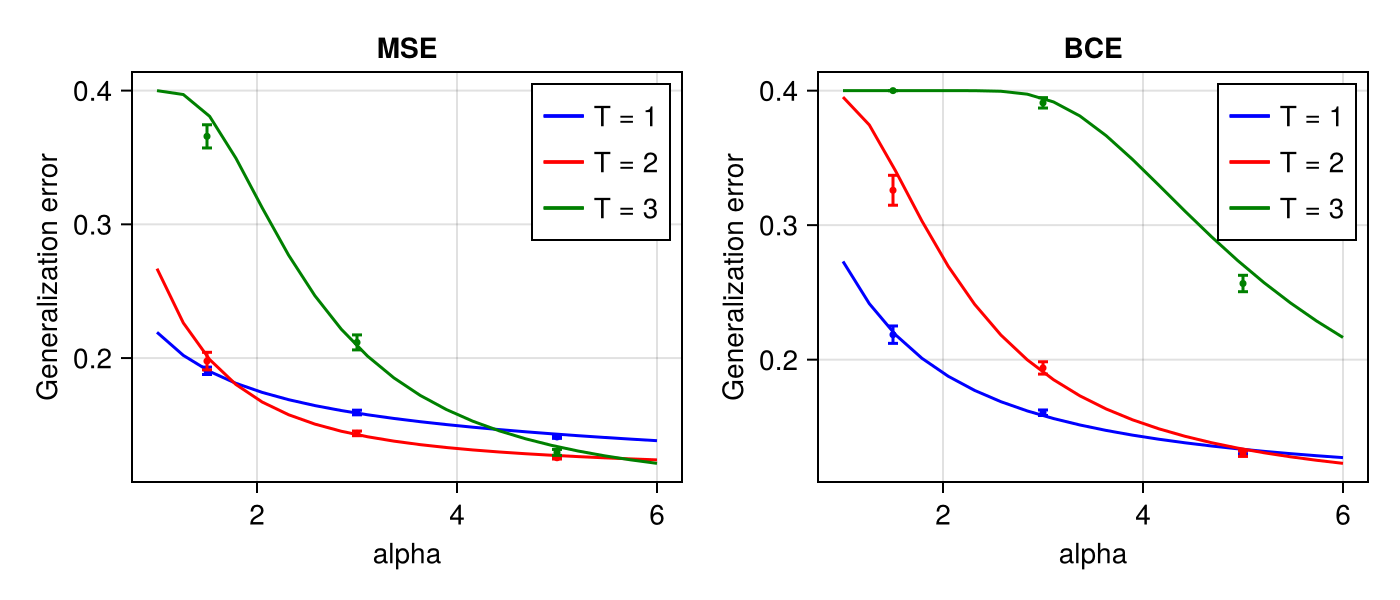

CairoMakie.Screen{IMAGE}


In [5]:
fig = Figure(size = (700, 300))

#* Plot generalization error
ax1 = Axis(fig[1, 1], xlabel = "alpha", ylabel = "Generalization error", title="MSE")
ax2 = Axis(fig[1, 2], xlabel = "alpha", ylabel = "Generalization error", title="BCE")
colors = [:blue, :red, :green, :orange, :purple]
for t in 1:T
    lines!(ax1, αs, error_theory_MSE[:, t], color = colors[t], label = "T = $t")
    errorbars!(ax1, αs_exp, error_mean_exp_MSE[:, t], error_std_exp_MSE[:, t], color = colors[t], label = "T = $t", whiskerwidth = 5.0)
    scatter!(ax1, αs_exp, error_mean_exp_MSE[:, t], color = colors[t], markersize = 5)
    lines!(ax2, αs, error_theory_BCE[:, t], color = colors[t], label = "T = $t")
    errorbars!(ax2, αs_exp, error_mean_exp_BCE[:, t], error_std_exp_BCE[:, t], color = colors[t], label = "T = $t", whiskerwidth = 5.0)
    scatter!(ax2, αs_exp, error_mean_exp_BCE[:, t], color = colors[t], markersize = 5)
end
axislegend(ax1, position = :rt, merge = true)
axislegend(ax2, position = :rt, merge = true)

display(fig)

# Optimal SD

In [6]:
function trial_param_tstage_MSE(λ, p)
    α, Δ, ρ, θ, T, nsamp, damping, tol, seed = p
    Q, m, χ, Q̂, m̂, χ̂, b, ite = t_replica(
        α, Δ, ρ, θ, T, λ, ones(T-1);
        nsamp = nsamp, damping = damping, tol = tol, max_iter = 1000, 
        seed = seed, adaptive_beta = true, error_type = :MSE
    )
    error = error01(ρ, Δ, Q, m, b, T)
    return error
end


function optimize_MSE(
    α, Δ, ρ, θ, T, nsamp, damping, tol, seed, 
    λ0, lb, ub;
    abstol = 1e-9, reltol = 1e-7, maxiters = 200, show_optimalparam = false
)
    p = α, Δ, ρ, θ, T, nsamp, damping, tol, seed
    f = OptimizationFunction(trial_param_tstage_MSE)
    prob = Optimization.OptimizationProblem(f, λ0, p, lb = lb, ub = ub)

    sol = solve(prob, NLopt.LN_SBPLX(), abstol=abstol, reltol=reltol, maxiters=maxiters)

    min_error = sol.minimum
    λopt = sol.minimizer

    if show_optimalparam == true
        Q, m, χ, Q̂, m̂, χ̂, b, ite = t_replica(
            α, Δ, ρ, θ, T, λopt, ones(T-1);
            nsamp = nsamp, damping = damping, tol = tol, max_iter = 1000, 
            seed = seed, adaptive_beta = true, error_type = :MSE
        )
        return min_error, λopt, diag(Q), m, b
    end

    return min_error, λopt
end

optimize_MSE (generic function with 1 method)

In [7]:
#* parameters
αs = 10 .^range(-1, stop = 2, length = 20)
Δ = 0.5
ρ = 0.5
θ = 0.3
error_type = :MSE
damping = 0.5
tol = 1e-9
error_improvement_tol = 0.0000001  
nsamp = 10^4
seed = 1234

T_search = 6
indexes = CartesianIndices((length(αs),))
min_errors = zeros(length(αs), T_search)
λopts = zeros(length(αs), T_search, T_search)
stop_T = zeros(length(αs))
optimal_mt = zeros(length(αs), T_search, T_search)
optimal_Qt = zeros(length(αs), T_search, T_search)
optimal_bt = zeros(length(αs), T_search, T_search)
p = Progress(length(indexes))


@showprogress for ind in indexes
    i, = Tuple(ind)
    α = αs[i]
    λ0 = ones(T_search) .* 1.0 
    pred_minerror = Inf 
    min_error = Inf
    λopt, optQ, optm, optb = nothing, nothing, nothing, nothing
    for t in 1:T_search

        lb = ones(t) .* 0.001
        ub = ones(t) .* 300.0  

        @suppress min_error, λopt, optQ, optm, optb = optimize_MSE(
            α, Δ, ρ, θ, t, nsamp, damping, tol, seed, 
            λ0[1:t], lb, ub, abstol = 1e-10, reltol = 1e-8, maxiters = 400, show_optimalparam = true
        )

        min_errors[i, t] = min_error

        if pred_minerror - min_error < error_improvement_tol 
            stop_T[i] = t
            #println("stop at $(t), α = $(α)")
            # 残りを現在のエラーで埋め尽くす
            for j in t+1:T_search
                min_errors[i, j] = min_error
            end
            break
        end
        pred_minerror = min_error

        optimal_mt[i, t, 1:t] = optm
        optimal_Qt[i, t, 1:t] = optQ
        optimal_bt[i, t, 1:t] = optb
        λopts[i, t, 1:t] = λopt

        if t == T_search
            stop_T[i] = T_search
        end
        λ0[1:t] .= λopt
    end
end

Progress: 100%|█████████████████████████████████████████| Time: 0:01:31


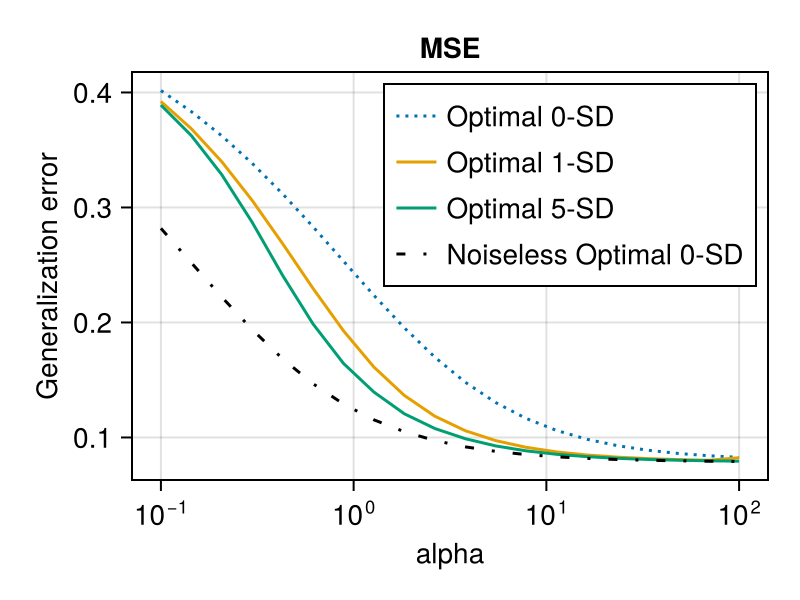

CairoMakie.Screen{IMAGE}


In [8]:
fig = Figure(size = (400, 300))

ax = Axis(fig[1, 1], xlabel = "alpha", ylabel = "Generalization error", title="MSE", xscale = log10)
lines!(ax, αs, min_errors[:, 1], linestyle = :dot, label = "Optimal 0-SD")
lines!(ax, αs, min_errors[:, 2], linestyle = :solid, label = "Optimal 1-SD")
lines!(ax, αs, min_errors[:, 6], linestyle = :solid, label = "Optimal 5-SD")
function H(x)
    1 - cdf(Normal(0, 1), x)
end
error_noiseless = zeros(length(αs))
for (i, α) in enumerate(αs)
    error_noiseless[i] = H(1/sqrt(Δ*(1+Δ/α)))
end
lines!(ax, αs, error_noiseless, color = :black, linestyle = (:dashdot, :loose), label = "Noiseless Optimal 0-SD")


axislegend(ax, position = :rt, merge = true)
display(fig)
